# cGAN using sandstone grayscale image data
*Jeremy Doan*

Adapted from reference architectures: 
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/
* https://github.com/qbxlvnf11/conditional-GAN/blob/main/conditional-GAN-generating-fashion-mnist.ipynb

Residual blocks: https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed

Image datasets used: 
* https://www.digitalrocksportal.org/projects/305
* 1024 random slices from the dataset were processed in ImageJ to be used for the total dataset

In [2]:
# Set up:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch import Tensor
import time
from torchvision.utils import make_grid
from collections import Counter
import tabulate
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import KFold


# # Set random seed for reproducibility
# manualSeed = 999

# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True)  # Needed for reproducible results

# Check CUDA and GPU
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda")


True
NVIDIA GeForce RTX 3060 Laptop GPU


## Parameters

In [3]:
# Define inputs

# Root directory for dataset
dataroot = r"C:\Users\johna\Downloads\research\trainingdata"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer. 64 for color, 28 for grayscale
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers --generator and discriminator--
lrg = 2.5e-3 # generator
lrd = 1.5e-3 # discriminator

# Beta1 hyperparameter for Adam optimizers, should be 0.5
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode
ngpu = 1

# Increase/decrease effect of vol_frac on training
loss_weight = 1
g_loss_weight = 1e-3

# List of phase names
phases = ["0: Pore", "1: Clay", "2: Quartz",
          "3: Feldspar", "4: Micas"]
num_phase = len(phases)
print(f"Number of phases: {num_phase}\n{phases}")

# Phase pixel values (obtained from ImageJ)
phase_pixels = [0, 64, 128, 192, 255]
print(f"From ImageJ: {phase_pixels}\n")

# Normalize
norm_pixels = [0, 64/255, 128/255, 192/255, 255/255]
print(f"Normalized: {norm_pixels}")

Number of phases: 5
['0: Pore', '1: Clay', '2: Quartz', '3: Feldspar', '4: Micas']
From ImageJ: [0, 64, 128, 192, 255]

Normalized: [0, 0.25098039215686274, 0.5019607843137255, 0.7529411764705882, 1.0]


## Dataloader and Image Processing

In [4]:
# Ensure phases are normalized properly
class RoundToPhases:
    def __call__(self, tensor):
        return torch.round(tensor * (num_phase-1)) / (num_phase-1)

Batch 0: torch.Size([64, 1, 28, 28])
Batch 1: torch.Size([64, 1, 28, 28])
Batch 2: torch.Size([64, 1, 28, 28])
Batch 3: torch.Size([64, 1, 28, 28])
Batch 4: torch.Size([64, 1, 28, 28])
Batch 5: torch.Size([64, 1, 28, 28])
Batch 6: torch.Size([64, 1, 28, 28])
Batch 7: torch.Size([64, 1, 28, 28])
Batch 8: torch.Size([64, 1, 28, 28])
Batch 9: torch.Size([64, 1, 28, 28])
Batch 10: torch.Size([64, 1, 28, 28])
Batch 11: torch.Size([64, 1, 28, 28])
Batch 12: torch.Size([51, 1, 28, 28])


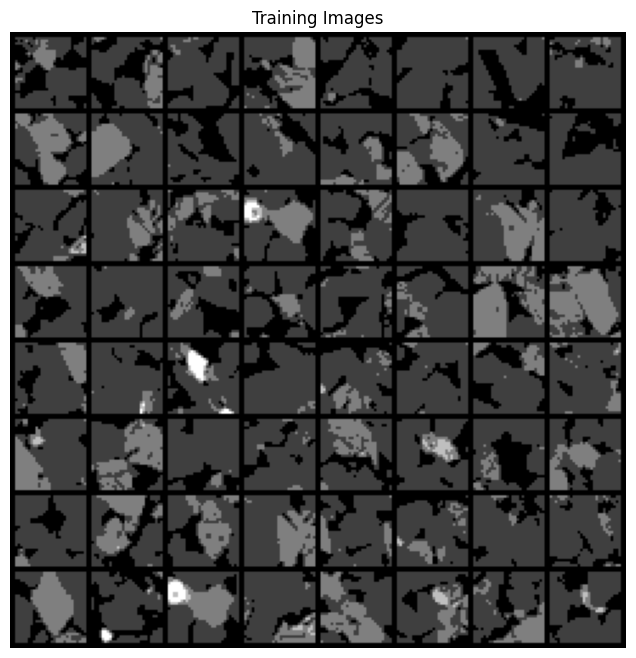

In [5]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               RoundToPhases(),
                           ]))
train_dset, test_dset = train_test_split(dataset, test_size=0.2, random_state=1)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
for i, data in enumerate(dataloader, 0):
    print(f"Batch {i}: {data[0].shape}")  # Check the shape of your input data
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Unique Pixel Values: [0.   0.25 0.5  0.75 1.  ]
Pixel Value Counts: {0.0: 118339, 0.25: 424547, 0.5: 97076, 0.75: 1751, 1.0: 383}


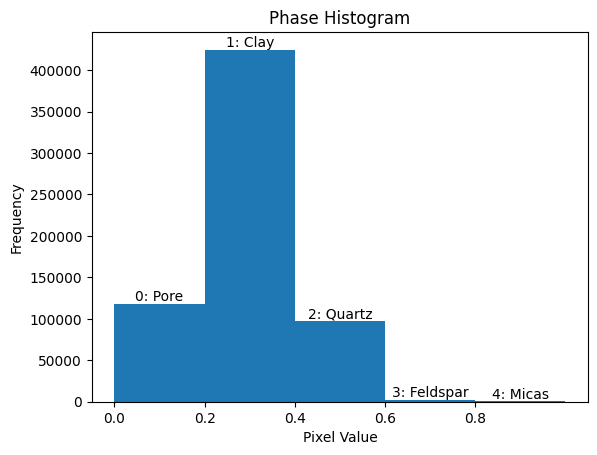

Max: 1.0, Min: 0.0


In [6]:
# Pixel values collection
pixel_values = []

for i, data in enumerate(dataloader):
    images = data[0].view(-1)
    pixel_values.extend(images.tolist())

# Convert to NumPy for easier manipulation
pixel_values = np.array(pixel_values)

# 1. Print unique pixel values
unique_values = np.unique(pixel_values)
print("Unique Pixel Values:", unique_values)

# 2. Print frequency of each pixel value
unique, counts = np.unique(pixel_values, return_counts=True)
pixel_value_counts = dict(zip(unique, counts))
print("Pixel Value Counts:", pixel_value_counts)

# Create histogram
bins = num_phase
counts, bin_edges, _ = plt.hist(pixel_values, bins=bins)

# Annotate the histogram
bin_width = bin_edges[1] - bin_edges[0]
for i, (count, edge) in enumerate(zip(counts, bin_edges[:-1])):
    plt.text(edge + bin_width / 2, count, 
             f"{phases[i]}", ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Phase Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
interval = (np.max(pixel_values) - np.min(pixel_values))/(bins)
plt.xticks(ticks=np.arange(np.min(pixel_values),np.max(pixel_values), interval))
plt.show()

# Print max and min pixel values
print(f"Max: {np.max(pixel_values)}, Min: {np.min(pixel_values)}")

## Setting Phase Ratio/Volume Fraction as Condition

In [7]:
# Get volume fractions based on pixel value/phase

# Index by phase i.e. [num phase 0, num phase 1, etc]
px_vals =[0, 0.25, 0.5, 0.75, 1]
real_vol_frac_data = []

# Load images from dataset
for img, _ in dataset:
    img_flat = img.flatten()

    # Calculate volume fractions
    total_pixels = img_flat.numel()
    fractions = []

    for value in unique_values:
        count = torch.sum(img_flat == value).item()  # Count pixels with this value
        fraction = count / total_pixels              # Compute volume fraction
        fractions.append(fraction)

    real_vol_frac_data.append(fractions)


# Print the volume fractions of the first 10 images (for reference)
print("Volume fractions (first 10 images):\n")
for i, fractions in enumerate(real_vol_frac_data):
    if i < 10:
        print(f"Image {i}: {', '.join(f'{v:.4f}' for v in fractions)}")
    else:
        break

# Summary statistics
max_fractions = np.max(real_vol_frac_data, axis=0)
min_fractions = np.min(real_vol_frac_data, axis=0)
avg_fractions = np.mean(real_vol_frac_data, axis=0)

print("\nSummary of volume fractions across all images:")
for i, value in enumerate(px_vals):
    print(f"Phase {phases[i]}: Max: {max_fractions[i]:.4f}, Min: {min_fractions[i]:.4f}, Avg: {avg_fractions[i]:.4f}")

# Use just the first 4 phase ratios for conditioning
real_vol_frac_data = [fractions[:4] for fractions in real_vol_frac_data]

# Check dim of volume fraction tensor
print(f"\nSize of vol frac tensor for conditioning: {np.shape(real_vol_frac_data)}")

Volume fractions (first 10 images):

Image 0: 0.1543, 0.4388, 0.4069, 0.0000, 0.0000
Image 1: 0.1735, 0.5702, 0.2564, 0.0000, 0.0000
Image 2: 0.1824, 0.5472, 0.2704, 0.0000, 0.0000
Image 3: 0.2462, 0.7232, 0.0306, 0.0000, 0.0000
Image 4: 0.1964, 0.6110, 0.1926, 0.0000, 0.0000
Image 5: 0.1633, 0.7997, 0.0370, 0.0000, 0.0000
Image 6: 0.1849, 0.7832, 0.0319, 0.0000, 0.0000
Image 7: 0.2232, 0.7130, 0.0638, 0.0000, 0.0000
Image 8: 0.1110, 0.7730, 0.0651, 0.0510, 0.0000
Image 9: 0.1110, 0.8661, 0.0230, 0.0000, 0.0000

Summary of volume fractions across all images:
Phase 0: Pore: Max: 0.5370, Min: 0.0332, Avg: 0.1864
Phase 1: Clay: Max: 0.9490, Min: 0.2870, Avg: 0.6609
Phase 2: Quartz: Max: 0.5931, Min: 0.0000, Avg: 0.1491
Phase 3: Feldspar: Max: 0.0753, Min: 0.0000, Avg: 0.0029
Phase 4: Micas: Max: 0.0714, Min: 0.0000, Avg: 0.0008

Size of vol frac tensor for conditioning: (1024, 4)


In [8]:
# Create new dataset from already loaded data and new labels
class PhaseDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder_dataset, vol_fracs):
        self.dataset = image_folder_dataset
        self.vol_fracs = vol_fracs 
    
    def __len__(self):
        return len(self.dataset) 
    
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        vol_frac = self.vol_fracs[idx]
        # vol_frac = torch.tensor(vol_frac, dtype=torch.float32)  
        return img, vol_frac  

# Create new phase dataset
phase_dataset = PhaseDataset(dataset, real_vol_frac_data)

# Verify the labels (phase ratios) for first 10 images
for idx, (img, phase_ratios) in enumerate(phase_dataset):
    print(f"Image {idx}: Phase Ratios: {phase_ratios}")
    if idx >= 9:
        break


# Create DataLoader
phase_dataloader = torch.utils.data.DataLoader(phase_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Image 0: Phase Ratios: [0.15433673469387754, 0.4387755102040816, 0.40688775510204084, 0.0]
Image 1: Phase Ratios: [0.17346938775510204, 0.5701530612244898, 0.25637755102040816, 0.0]
Image 2: Phase Ratios: [0.18239795918367346, 0.5471938775510204, 0.27040816326530615, 0.0]
Image 3: Phase Ratios: [0.2461734693877551, 0.7232142857142857, 0.030612244897959183, 0.0]
Image 4: Phase Ratios: [0.19642857142857142, 0.610969387755102, 0.19260204081632654, 0.0]
Image 5: Phase Ratios: [0.16326530612244897, 0.7997448979591837, 0.036989795918367346, 0.0]
Image 6: Phase Ratios: [0.18494897959183673, 0.7831632653061225, 0.03188775510204082, 0.0]
Image 7: Phase Ratios: [0.22321428571428573, 0.7130102040816326, 0.06377551020408163, 0.0]
Image 8: Phase Ratios: [0.11096938775510204, 0.7729591836734694, 0.06505102040816327, 0.05102040816326531]
Image 9: Phase Ratios: [0.11096938775510204, 0.8660714285714286, 0.02295918367346939, 0.0]


## Generator

In [9]:
# Generator with Residual Block (modified for cGAN)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=(3, 3), 
            padding='same', 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=(3, 3), 
            padding='same', 
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernel_size=(3, 3), 
                    padding='same', 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: Tensor) -> Tensor:
        identity = self.downsample(x) if self.downsample else x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x + identity)

        return x


class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        # Embedding layer for phase_ratios
        self.phase_ratios_fc = nn.Linear(1, nz)
            
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + 1, ngf * 8, 4, 1, 0, bias=False), # Add phase_ratios to input channel as a single value
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(),
            # ResidualBlock(ngf * 8, ngf * 8),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            # ResidualBlock(ngf * 4, ngf * 4),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            # ResidualBlock(ngf * 2, ngf * 2),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            # ResidualBlock(ngf, ngf),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, noise, phase_ratios): 
        # Reshape phase_ratios to match the noise dimensions
        phase_ratios = phase_ratios.unsqueeze(1).unsqueeze(2).unsqueeze(3)  # Add extra dimensions for batch, channel, height, and width
        phase_ratios = phase_ratios.expand(phase_ratios.size(0), 1, noise.size(2), noise.size(3))  # Expand to match the noise tensor size
        
        # Concatenate noise and phase_ratios
        combined_input = torch.cat((noise, phase_ratios), dim=1)  # Concatenate along the channel dimension
        
        # Pass the combined input through the generator
        x = self.main(combined_input)
        
        # Optional: Resize the output image (if needed)
        return F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)


## Discriminator

In [10]:
# Discriminator (modified for cGAN)

class Discriminator(nn.Module):
    def __init__(self, ngpu, nc, ndf):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        # Embedding layer for phase_ratios
        self.vol_fraction_fc = nn.Linear(1, nz)

        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False), # Include phase_ratios
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf),
            nn.Dropout(0.25), # Introducing dropout layers to prevent overfitting
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            # state size. (ndf*4) x 3 x 3
            nn.Conv2d(ndf * 4, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
            # output size. 1 x 1 x 1 (probability)
        )
    
    def forward(self, img, phase_ratios):
        # Concatenate image and phase_ratios (expand phase_ratios to match image dimensions)
        phase_ratios = phase_ratios.view(-1, 1, 1, 1).expand(-1, 1, img.size(2), img.size(3))  # Match dimensions

        combined_input = torch.cat((img, phase_ratios), dim=1)  # Concatenate along channel dimension
        return self.main(combined_input)


## Instantiate cGAN

In [11]:
# Initializing weights

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
def get_cgan():
    netG = Generator(ngpu, nz, ngf, nc).to(device)
    netG.apply(weights_init)
    
    netD = Discriminator(ngpu, nc, ndf).to(device)
    netD.apply(weights_init)
    
    return netG, netD

# Instantiate the models
netG, netD = get_cgan()

# Print the model architectures
print(netG)
print(netD)

Generator(
  (phase_ratios_fc): Linear(in_features=1, out_features=100, bias=True)
  (main): Sequential(
    (0): ConvTranspose2d(101, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

In [13]:
# Create a batch of noise vectors
noise = torch.randn(16, nz, 1, 1, device=device)
# random_pr = torch.randint(0, 2, (16,), device=device)
random_pr = (np.min(real_vol_frac_data) + (np.max(real_vol_frac_data)-np.min(real_vol_frac_data))) * torch.rand(16, device=device)

# Generate a batch of images
fake_images = netG(noise, random_pr)
print(f"Generator output: {fake_images.size()}") 

# Pass fake images through discriminator
output = netD(fake_images, random_pr)
print(f"Discriminator output: {output.size()}") 


Generator output: torch.Size([16, 1, 28, 28])
Discriminator output: torch.Size([16, 1, 1, 1])


## Loss Function

In [14]:
# Rounding function for training loop
class RoundToPhasesTrain:
    def __init__(self):
        self.num_phase = num_phase

    def __call__(self, tensor):
        return torch.round(tensor * (self.num_phase - 1)) / (self.num_phase - 1)

In [15]:
class Vol_Frac_Loss(nn.Module):
    def __init__(self):
        super(Vol_Frac_Loss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, fake_vol_frac, real_vol_frac):
        
        # Compute batch mean loss
        batch_loss = self.mse_loss(fake_vol_frac, real_vol_frac)
        return batch_loss

## Training Loop

In [16]:
# Calculate phase ratios for phases 0-3

def get_phase_ratios(images):
    phase_ratios = []

    # Load images from dataset
    for img in images:

        fractions= []

        for value in unique_values:
            count = torch.sum(img == value).item()  # Count pixels with this value
            fraction = count / (img.size(1) * img.size(2))   # Compute volume fraction
            fractions.append(fraction)

    phase_ratios.append(fractions[:4])

    return torch.tensor(phase_ratios, dtype=torch.float, device=images.device)

In [17]:
def train_cgan(netG, netD, n_epoch, batch_size, dataloader, criterionD, criterionG, optimizerD, optimizerG, fixed_noise, real_label, fake_label, device, phase_ratio_loss_fn, round_fn):
    # Losses and image list for tracking
    G_losses = []
    D_losses = []
    PR_losses = []
    img_list = []

    # Timer
    start_time = time.time()

    # Training Loop
    for epoch in range(n_epoch):
        for i, data in enumerate(dataloader, 0):
            # Unpack real data and vol_frac
            real_cpu, real_vol_frac = data
            batch_size = real_cpu.size(0)

            real_vol_frac = torch.stack([real_vol_frac[0], real_vol_frac[1], real_vol_frac[2], real_vol_frac[3]], dim=1).float()
            real_vol_frac = real_vol_frac.to(device, dtype=torch.float32)

            real_vol_frac_tensor = torch.tensor(real_vol_frac, device=device)
            real_vol_frac_mean = torch.mean(real_vol_frac_tensor, dim=1)
            random_pr = real_vol_frac_mean[:batch_size]

            # Update Discriminator
            netD.zero_grad()
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            output = netD(real_cpu.to(device), random_pr).view(-1)
            errD_real = criterionD(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # Generate fake data
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise, random_pr).detach()
            label.fill_(fake_label)
            output = netD(fake, random_pr).view(-1)
            errD_fake = criterionD(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            # Update Generator
            netG.zero_grad()
            label.fill_(real_label)
            fake = netG(noise, random_pr)
            output = netD(fake, random_pr).view(-1)
            errG_adv = criterionG(output, label)

            # Calculate vol_frac loss
            fake_test = round_fn(fake)
            fake_vol_frac = get_phase_ratios(fake_test)
            PR_loss = loss_weight * phase_ratio_loss_fn(fake_vol_frac, real_vol_frac)
            total_G_loss = g_loss_weight * errG_adv + PR_loss  # Combine adversarial and vol_frac losses
            total_G_loss.backward()
            optimizerG.step()

            # Tracking losses
            G_losses.append(total_G_loss.item())
            D_losses.append(errD.item())
            PR_losses.append(PR_loss.item())

            # Print and save losses
            if i % 1 == 0:
                print(f'[{epoch}/{n_epoch}] [{i}/{len(dataloader)}] || ' 
                      f'Loss_D: {errD.item()} Loss_G: {errG_adv.item()} || '
                      f'PR Loss: {PR_loss.item()} || '
                      f'D(x): {D_x} D(G(z)): {D_G_z1} / {output.mean().item()} ')

            # Save generated images at the end of each epoch
            if i == len(dataloader) - 1 or epoch == n_epoch - 1:
                with torch.no_grad():
                    fixed_vol_frac = random_pr[:fixed_noise.size(0)]
                    fake = netG(fixed_noise, fixed_vol_frac).detach().cpu()
                    fake = round_fn(fake)
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # Timer end
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTraining Complete! \nElapsed time: {elapsed_time:.2f} seconds")

    return G_losses, D_losses, PR_losses, img_list

In [18]:
print("-------CGAN TRAINING-------------")
netG, netD = get_cgan()

# Define loss functions and other parameters
criterionD = nn.BCELoss() 
criterionG = nn.BCELoss()
prG = Vol_Frac_Loss() 
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
round_fn = RoundToPhasesTrain()

real_label = 1.0 # Label smoothening
fake_label = 0.1

optimizerD = optim.Adam(netD.parameters(), lr=lrd, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrg, betas=(beta1, 0.999))

# Call training function
G_losses, D_losses, PR_losses, img_list = train_cgan(
    netG, netD, n_epoch=num_epochs, batch_size=batch_size,
    dataloader=phase_dataloader, criterionD=criterionD, criterionG=criterionG,
    optimizerD=optimizerD, optimizerG=optimizerG, fixed_noise=fixed_noise,
    real_label=real_label, fake_label=fake_label, device=device, round_fn=round_fn,
    phase_ratio_loss_fn=prG
)


-------CGAN TRAINING-------------


C:\Users\johna\AppData\Local\Temp\ipykernel_12548\2567998267.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_vol_frac_tensor = torch.tensor(real_vol_frac, device=device)
c:\Users\johna\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0/200] [0/16] || Loss_D: 1.5137748718261719 Loss_G: 6.148952960968018 || PR Loss: 0.31859612464904785 || D(x): 0.45287230610847473 D(G(z)): 0.41816389560699463 / 0.0030425828881561756 
[0/200] [1/16] || Loss_D: 4.285924911499023 Loss_G: 11.527679443359375 || PR Loss: 0.23126131296157837 || D(x): 0.6679794788360596 D(G(z)): 0.9788288474082947 / 1.4596454093407374e-05 
[0/200] [2/16] || Loss_D: 3.5469794273376465 Loss_G: 6.639603614807129 || PR Loss: 0.1906406581401825 || D(x): 0.1325230896472931 D(G(z)): 0.0001302172167925164 / 0.0018258666386827826 
[0/200] [3/16] || Loss_D: 0.6695209741592407 Loss_G: 2.116594076156616 || PR Loss: 0.13760283589363098 || D(x): 0.7807470560073853 D(G(z)): 0.19131219387054443 / 0.15720048546791077 
[0/200] [4/16] || Loss_D: 2.3412177562713623 Loss_G: 10.449647903442383 || PR Loss: 0.11996996402740479 || D(x): 0.9668096899986267 D(G(z)): 0.9034450054168701 / 4.216865636408329e-05 
[0/200] [5/16] || Loss_D: 1.0700433254241943 Loss_G: 10.211950302124023 || 

## Results

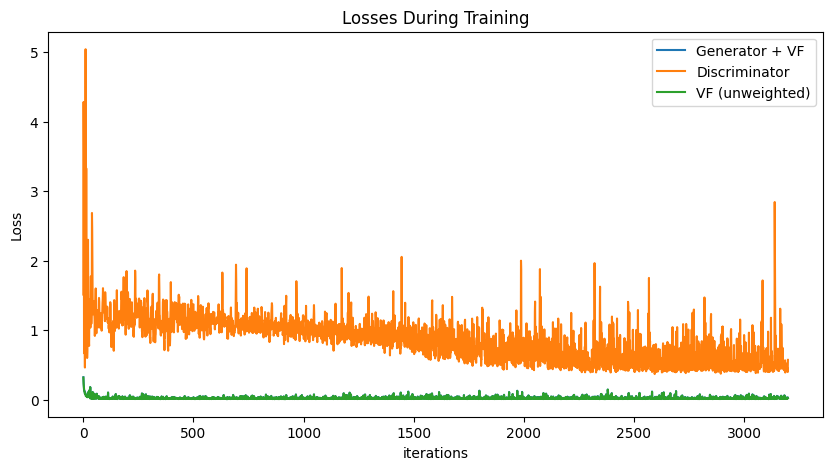

Parameters:
- Epochs: 200
- Batch Size: 64
- Generator LR: 0.0025
- Discriminator LR: 0.0015
- Generator Loss: BCELoss() + Vol_Frac_Loss(
  (mse_loss): MSELoss()
)
- Discriminator Loss: BCELoss()
- PR Loss Weight: 1
- G Loss Weight: 0.001


In [19]:
# Visualize training
plt.figure(figsize=(10,5))
plt.title("Losses During Training")
plt.plot(G_losses, label="Generator + VF")
plt.plot(D_losses, label="Discriminator")
plt.plot(PR_losses, label="VF (unweighted)")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

print("Parameters:")
print(f"- Epochs: {num_epochs}")
print(f"- Batch Size: {batch_size}")
print(f"- Generator LR: {lrg}")
print(f"- Discriminator LR: {lrd}")
print(f"- Generator Loss: {criterionG} + {prG}")
print(f"- Discriminator Loss: {criterionD}")
print(f"- PR Loss Weight: {loss_weight}")
print(f"- G Loss Weight: {g_loss_weight}")


In [20]:
# Ensure phases are normalized properly
def RoundToPhases(tensor):

    return torch.round(tensor * (num_phase-1)) / (num_phase-1)

In [34]:
# # Plot progression
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Fake Images")
# ims = [[plt.imshow((np.transpose(i,(1,2,0))), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

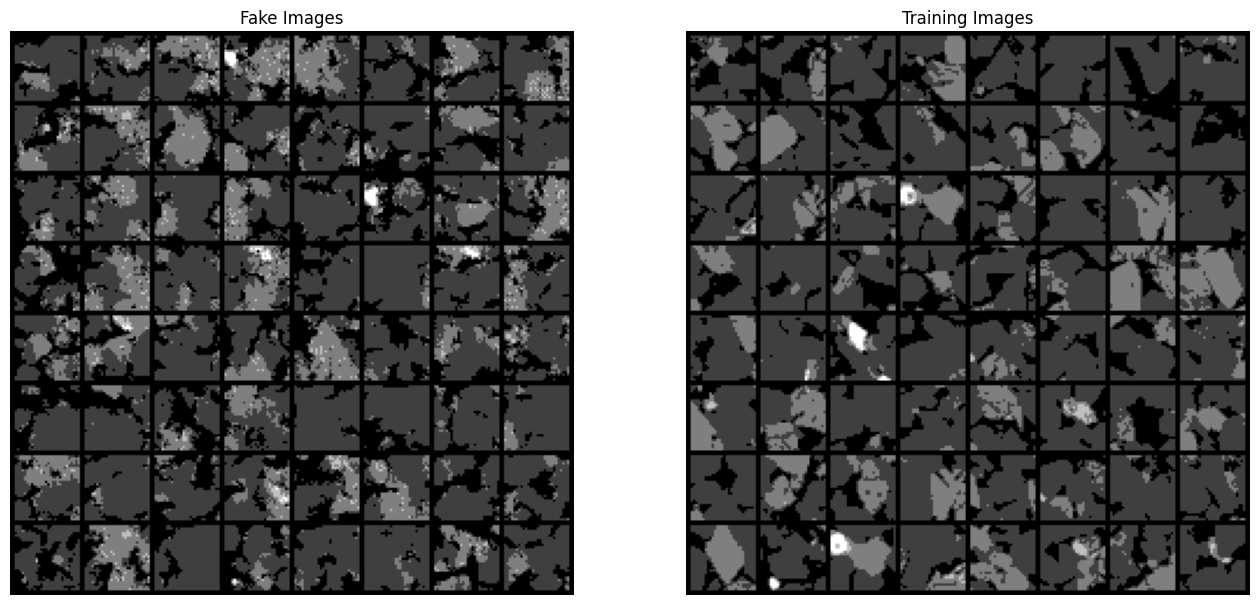

In [22]:
# Compare generated images to training set
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].axis("off")
axs[0].set_title("Fake Images")
ims = [[axs[0].imshow(RoundToPhases(np.transpose(i,(1,2,0))), animated=True)] for i in img_list]

axs[1].axis("off")
axs[1].set_title("Training Images")
axs[1].imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.show()

Unique Pixel Values (Real): [0.   0.25 0.5  0.75 1.  ]
Unique Pixel Values (Fake): [0.   0.25 0.5  0.75 1.  ]


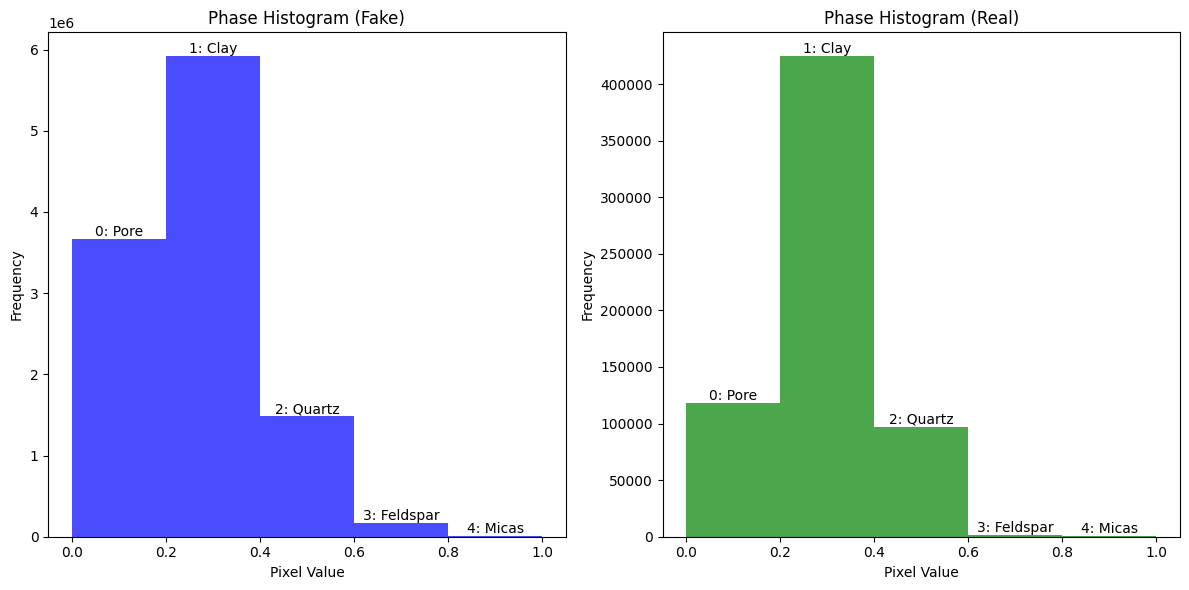

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

# Pixel values collection for real images
pixel_values_real = []
for data in dataloader:
    images = data[0].view(-1)  
    pixel_values_real.extend(images.tolist())

pixel_values_real = np.array(pixel_values_real) 
unique_values_real = np.unique(pixel_values_real)
print("Unique Pixel Values (Real):", unique_values_real)

pixel_values_fake = []
last_epoch = img_list[-65:-1]
for img in last_epoch:
    fake_img = img.cpu().detach().flatten()
    fake_img = RoundToPhases(fake_img)
    pixel_values_fake.extend(fake_img.tolist())

unique_values_fake = np.unique(pixel_values_fake)
print("Unique Pixel Values (Fake):", unique_values_fake)

# Subplot 1: Histogram for Fake Images
bins_fake = num_phase
counts_fake, bin_edges_fake, _ = axs[0].hist(pixel_values_fake, bins=bins_fake, color='blue', alpha=0.7)

# Annotate histogram
max_phases = min(len(bin_edges_fake) - 1, len(phases))
for i in range(max_phases):
    count, edge = counts_fake[i], bin_edges_fake[i]
    axs[0].text(edge + (bin_edges_fake[1] - bin_edges_fake[0]) / 2, count,
                f"{phases[i]}", ha='center', va='bottom', fontsize=10)

axs[0].set_title("Phase Histogram (Fake)")
axs[0].set_xlabel("Pixel Value")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(np.linspace(np.min(pixel_values_fake), np.max(pixel_values_fake), bins_fake + 1))

# Subplot 2: Histogram for Real Images
bins_real = num_phase
counts_real, bin_edges_real, _ = axs[1].hist(pixel_values_real, bins=bins_real, color='green', alpha=0.7)

# Annotate histogram
max_phases = min(len(bin_edges_real) - 1, len(phases))
for i in range(max_phases):
    count, edge = counts_real[i], bin_edges_real[i]
    axs[1].text(edge + (bin_edges_real[1] - bin_edges_real[0]) / 2, count,
                f"{phases[i]}", ha='center', va='bottom', fontsize=10)

axs[1].set_title("Phase Histogram (Real)")
axs[1].set_xlabel("Pixel Value")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks(np.linspace(np.min(pixel_values_real), np.max(pixel_values_real), bins_real + 1))

# Adjust layout and display
plt.tight_layout()
plt.show()


In [45]:
# Load images from dataset
fake_vol_frac_data = []
for img in last_epoch:
    img_flat = img.flatten()

    # Calculate volume fractions
    total_pixels = img_flat.numel()
    fractions = []

    for value in unique_values:
        count = torch.sum(img_flat == value).item()  # Count pixels with this value
        fraction = count / total_pixels              # Compute volume fraction
        fractions.append(fraction)

    fake_vol_frac_data.append(fractions)

    # Summary statistics
max_fractions = np.max(fake_vol_frac_data, axis=0)
min_fractions = np.min(fake_vol_frac_data, axis=0)
avg_fractions = np.mean(fake_vol_frac_data, axis=0)

print("\nSummary of volume fractions across fake images:")
for i, value in enumerate(px_vals):
    print(f"Phase {phases[i]}: Max: {max_fractions[i]:.4f}, Min: {min_fractions[i]:.4f}, Avg: {avg_fractions[i]:.4f}")

# Index by phase i.e. [num phase 0, num phase 1, etc]
px_vals =[0, 0.25, 0.5, 0.75, 1]
real_vol_frac_data = []

# Load images from dataset
for img, _ in dataset:
    img_flat = img.flatten()

    # Calculate volume fractions
    total_pixels = img_flat.numel()
    fractions = []

    for value in unique_values:
        count = torch.sum(img_flat == value).item()  # Count pixels with this value
        fraction = count / total_pixels              # Compute volume fraction
        fractions.append(fraction)

    real_vol_frac_data.append(fractions)
    
# Summary statistics
max_fractions = np.max(real_vol_frac_data, axis=0)
min_fractions = np.min(real_vol_frac_data, axis=0)
avg_fractions = np.mean(real_vol_frac_data, axis=0)

print("\nSummary of volume fractions across real images:")
for i, value in enumerate(px_vals):
    print(f"Phase {phases[i]}: Max: {max_fractions[i]:.4f}, Min: {min_fractions[i]:.4f}, Avg: {avg_fractions[i]:.4f}")


Summary of volume fractions across fake images:
Phase 0: Pore: Max: 0.3490, Min: 0.3058, Avg: 0.3258
Phase 1: Clay: Max: 0.5537, Min: 0.0000, Avg: 0.4934
Phase 2: Quartz: Max: 0.1727, Min: 0.0000, Avg: 0.1317
Phase 3: Feldspar: Max: 0.0536, Min: 0.0000, Avg: 0.0065
Phase 4: Micas: Max: 0.0063, Min: 0.0000, Avg: 0.0008

Summary of volume fractions across real images:
Phase 0: Pore: Max: 0.5370, Min: 0.0332, Avg: 0.1864
Phase 1: Clay: Max: 0.9490, Min: 0.2870, Avg: 0.6609
Phase 2: Quartz: Max: 0.5931, Min: 0.0000, Avg: 0.1491
Phase 3: Feldspar: Max: 0.0753, Min: 0.0000, Avg: 0.0029
Phase 4: Micas: Max: 0.0714, Min: 0.0000, Avg: 0.0008


## Testing

In [25]:
# Save and load generator state

torch.save(netG.state_dict(), 'c_generator.pth')
netG.load_state_dict(torch.load('c_generator.pth'))
netG.eval()

Generator(
  (phase_ratios_fc): Linear(in_features=1, out_features=100, bias=True)
  (main): Sequential(
    (0): ConvTranspose2d(101, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

### Images

In [26]:
test_dataloader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
test_batch = next(iter(dataloader))

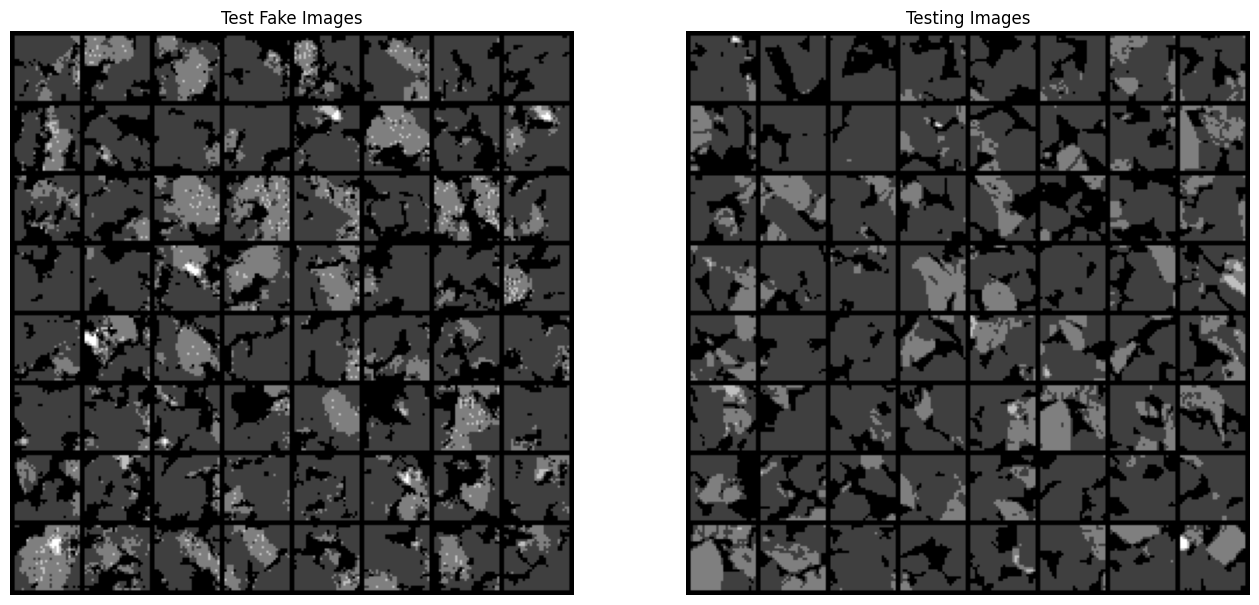

In [27]:
# Generate images
fake_batch=batch_size
noise = torch.randn(fake_batch, nz, 1, 1, device=device)
real_vol_frac_tensor = torch.tensor(real_vol_frac_data, device=device)
real_vol_frac_mean = torch.mean(real_vol_frac_tensor, dim=1)
random_pr = real_vol_frac_mean[:fake_batch]
with torch.no_grad():
    fake_images = netG(noise, random_pr)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].axis("off")
axs[0].set_title("Test Fake Images")
axs[0].imshow(RoundToPhases(np.transpose(vutils.make_grid(fake_images[:].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0))))

axs[1].axis("off")
axs[1].set_title("Testing Images")
axs[1].imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.show()

### Histogram

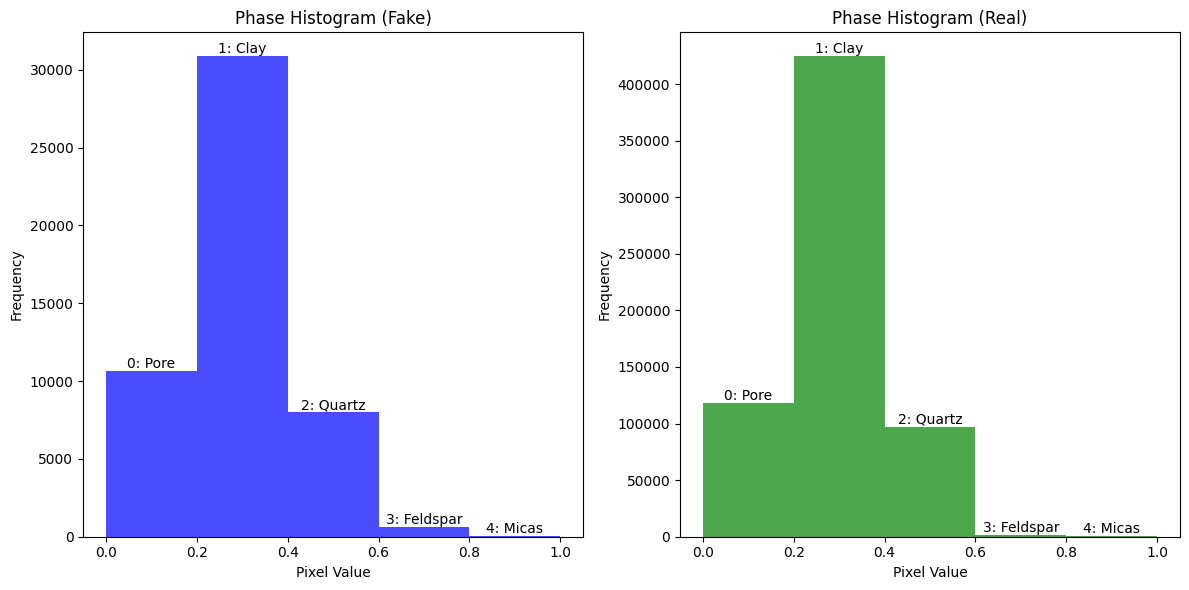

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 
fake_images = RoundToPhases(fake_images)
# Pixel values collection for real images
pixel_values_real = []
for data in dataloader:
    images = data[0].view(-1)  
    pixel_values_real.extend(images.tolist())

pixel_values_real = np.array(pixel_values_real) 

# Pixel values for fake images (last epoch)\
pixel_values_fake = []
for img in fake_images:
    fake_img = img.cpu().detach().flatten()
    pixel_values_fake.extend(fake_img.tolist())

# Subplot 1: Histogram for Fake Images
bins_fake = num_phase
counts_fake, bin_edges_fake, _ = axs[0].hist(pixel_values_fake, bins=bins_fake, color='blue', alpha=0.7)

# Annotate histogram
max_phases = min(len(bin_edges_fake) - 1, len(phases))
for i in range(max_phases):
    count, edge = counts_fake[i], bin_edges_fake[i]
    axs[0].text(edge + (bin_edges_fake[1] - bin_edges_fake[0]) / 2, count,
                f"{phases[i]}", ha='center', va='bottom', fontsize=10)

axs[0].set_title("Phase Histogram (Fake)")
axs[0].set_xlabel("Pixel Value")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(np.linspace(np.min(pixel_values_fake), np.max(pixel_values_fake), bins_fake + 1))

# Subplot 2: Histogram for Real Images
bins_real = num_phase
counts_real, bin_edges_real, _ = axs[1].hist(pixel_values_real, bins=bins_real, color='green', alpha=0.7)

# Annotate histogram
max_phases = min(len(bin_edges_real) - 1, len(phases))
for i in range(max_phases):
    count, edge = counts_real[i], bin_edges_real[i]
    axs[1].text(edge + (bin_edges_real[1] - bin_edges_real[0]) / 2, count,
                f"{phases[i]}", ha='center', va='bottom', fontsize=10)

axs[1].set_title("Phase Histogram (Real)")
axs[1].set_xlabel("Pixel Value")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks(np.linspace(np.min(pixel_values_real), np.max(pixel_values_real), bins_real + 1))

# Adjust layout and display
plt.tight_layout()
plt.show()


In [29]:
# Load images from dataset
unique_values = np.unique(pixel_values_fake)
test_vol_frac_data = []
for img in fake_images:
    fake_img = img.flatten()

    # Calculate volume fractions
    total_pixels = fake_img.numel()
    fractions = []

    for value in unique_values:
        count = torch.sum(fake_img == value).item()  # Count pixels with this value
        fraction = count / total_pixels              # Compute volume fraction
        fractions.append(fraction)

    test_vol_frac_data.append(fractions)

    # Summary statistics
test_max_fractions = np.max(test_vol_frac_data, axis=0)
test_min_fractions = np.min(test_vol_frac_data, axis=0)
test_avg_fractions = np.mean(test_vol_frac_data, axis=0)

print("\nSummary of volume fractions across fake images:")
for i, value in enumerate(px_vals):
    print(f"Phase {phases[i]}: Max: {test_max_fractions[i]:.4f}, Min: {test_min_fractions[i]:.4f}, Avg: {test_avg_fractions[i]:.4f}")
    
# Summary statistics
max_fractions = np.max(real_vol_frac_data, axis=0)
min_fractions = np.min(real_vol_frac_data, axis=0)
avg_fractions = np.mean(real_vol_frac_data, axis=0)

print("\nSummary of volume fractions across real images:")
for i, value in enumerate(px_vals):
    print(f"Phase {phases[i]}: Max: {max_fractions[i]:.4f}, Min: {min_fractions[i]:.4f}, Avg: {avg_fractions[i]:.4f}")


Summary of volume fractions across fake images:
Phase 0: Pore: Max: 0.3712, Min: 0.0816, Avg: 0.2124
Phase 1: Clay: Max: 0.8827, Min: 0.1849, Avg: 0.6151
Phase 2: Quartz: Max: 0.5204, Min: 0.0000, Avg: 0.1592
Phase 3: Feldspar: Max: 0.0599, Min: 0.0000, Avg: 0.0118
Phase 4: Micas: Max: 0.0242, Min: 0.0000, Avg: 0.0014

Summary of volume fractions across real images:
Phase 0: Pore: Max: 0.5370, Min: 0.0332, Avg: 0.1864
Phase 1: Clay: Max: 0.9490, Min: 0.2870, Avg: 0.6609
Phase 2: Quartz: Max: 0.5931, Min: 0.0000, Avg: 0.1491
Phase 3: Feldspar: Max: 0.0753, Min: 0.0000, Avg: 0.0029
Phase 4: Micas: Max: 0.0714, Min: 0.0000, Avg: 0.0008


### SSIM

In [30]:
# Compare images using SSIM
real_images = test_batch[0]
# Convert tensors to NumPy arrays and remove the channel dimension
fake_np = fake_images.squeeze(1).cpu().numpy()  
real_np = real_images.squeeze(1).cpu().numpy()  

# Compute SSIM
ssim_values = []
for fake_img, real_img in zip(fake_np, real_np):
    img_ssim = ssim(fake_img, real_img, data_range=1)
    ssim_values.append(img_ssim)

mean_ssim = sum(ssim_values) / len(ssim_values)
print(f"Mean SSIM: {mean_ssim}")


Mean SSIM: 0.07013728466757824
